<a href="https://colab.research.google.com/github/Amy-Vizard-Lovett/Data-Science-Porfolio/blob/main/C02EmissionsForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
file_path = '/content/H, D, C & Other C02 Emissions.csv'
df = pd.read_csv(file_path)
df.head()

,Industry Group,Year,Volume
0,Other,1990,6209.9
1,Other,1991,6424.8
2,Other,1992,6452.9
3,Other,1993,6008.1
4,Other,1994,6080.2


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpudvwn6g5/tlspshv5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpudvwn6g5/veyag4j4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53782', 'data', 'file=/tmp/tmpudvwn6g5/tlspshv5.json', 'init=/tmp/tmpudvwn6g5/veyag4j4.json', 'output', 'file=/tmp/tmpudvwn6g5/prophet_model7ohilz4z/prophet_model-20240808125421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:54:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:54:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit


Comparison for Other:
  Prophet - MAE: 5274.74, MSE: 170189022.48, R²: -0.01
  ARIMA - MAE: 256.79, MSE: 4308771.99, R²: 0.97
  Linear Regression - MAE: 5272.61, MSE: 168853703.06, R²: 0.00
  Best Model: ARIMA

Comparison for C:
  Prophet - MAE: 2089.09, MSE: 14216358.37, R²: -0.01
  ARIMA - MAE: 242.41, MSE: 940639.18, R²: 0.93
  Linear Regression - MAE: 2037.38, MSE: 13867394.95, R²: 0.01
  Best Model: ARIMA

Comparison for D:
  Prophet - MAE: 28143.67, MSE: 1520442659.05, R²: 0.11
  ARIMA - MAE: 3728.91, MSE: 147139543.43, R²: 0.91
  Linear Regression - MAE: 31266.99, MSE: 1690900594.34, R²: 0.01
  Best Model: ARIMA

Comparison for H:
  Prophet - MAE: 8763.97, MSE: 127053381.42, R²: 0.00
  ARIMA - MAE: 940.50, MSE: 8847956.84, R²: 0.93
  Linear Regression - MAE: 8784.56, MSE: 127683075.23, R²: 0.00
  Best Model: ARIMA


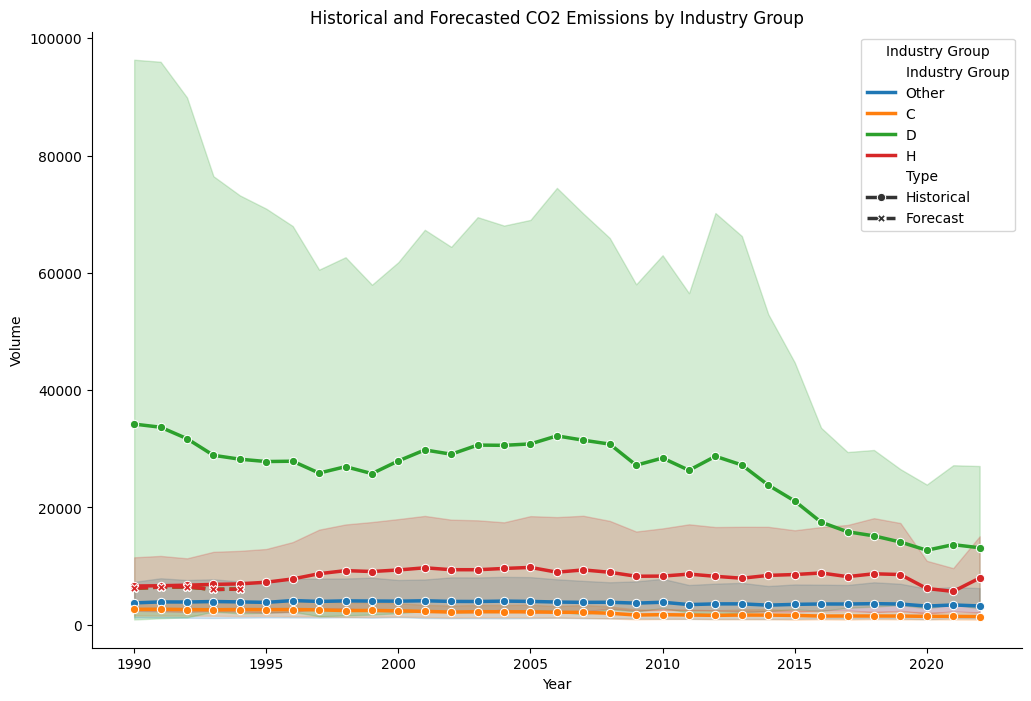

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
file_path = '/content/H, D, C & Other C02 Emissions.csv'
df = pd.read_csv(file_path)

# Filter the DataFrame for the desired industry groups
industry_groups = ['Other', 'C', 'D', 'H']
df_filtered = df[df['Industry Group'].isin(industry_groups)]

# Initialize dictionaries to store forecasts and evaluation metrics for all models
prophet_forecasts = {}
arima_forecasts = {}
linear_forecasts = {}
prophet_metrics = {}
arima_metrics = {}
linear_metrics = {}

# Function to evaluate the model
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, r2

# Iterate over the industry groups and create forecasts using all three models
for group in industry_groups:
    df_group = df_filtered[df_filtered['Industry Group'] == group]

    # Check if the DataFrame for the current group is empty
    if df_group.empty:
        print(f"No data available for industry group: {group}")
        continue

    # Prepare data for Prophet
    df_group_prophet = df_group.rename(columns={'Year': 'ds', 'Volume': 'y'})

    # Fit the Prophet model
    prophet_model = Prophet()
    prophet_model.fit(df_group_prophet)

    # Create a DataFrame for future dates
    future_years = prophet_model.make_future_dataframe(periods=5, freq='Y')

    # Predict future values with Prophet
    prophet_forecast = prophet_model.predict(future_years)
    prophet_forecast = prophet_forecast[['ds', 'yhat']].tail(5)
    prophet_forecast = prophet_forecast.rename(columns={'ds': 'Year', 'yhat': 'Volume'})
    prophet_forecast['Industry Group'] = group
    prophet_forecasts[group] = prophet_forecast

    # Evaluate Prophet model
    y_true_prophet = df_group_prophet['y']
    y_pred_prophet = prophet_model.predict(df_group_prophet[['ds']])['yhat']
    prophet_metrics[group] = evaluate_model(y_true_prophet, y_pred_prophet)

    # Prepare data for ARIMA
    df_group_arima = df_group.set_index('Year')['Volume']

    # Fit the ARIMA model
    arima_model = ARIMA(df_group_arima, order=(1, 1, 1))
    arima_fit = arima_model.fit()

    # Predict future values with ARIMA
    arima_forecast = arima_fit.forecast(steps=5)
    arima_forecast = pd.DataFrame(arima_forecast).reset_index()
    arima_forecast.columns = ['Year', 'Volume']
    arima_forecast['Year'] = arima_forecast['Year'] + df_group_arima.index[-1]
    arima_forecast['Industry Group'] = group
    arima_forecasts[group] = arima_forecast

    # Evaluate ARIMA model
    y_true_arima = df_group_arima
    y_pred_arima = arima_fit.fittedvalues
    arima_metrics[group] = evaluate_model(y_true_arima, y_pred_arima)

    # Prepare data for Linear Regression
    X = df_group[['Year']]
    y = df_group['Volume']

    # Fit the Linear Regression model
    linear_model = LinearRegression()
    linear_model.fit(X, y)

    # Predict future values with Linear Regression
    linear_forecast_years = pd.DataFrame([[2023], [2024], [2025], [2026], [2027]], columns=['Year'])
    linear_forecast = linear_model.predict(linear_forecast_years)
    linear_forecast_df = pd.DataFrame({'Year': linear_forecast_years['Year'], 'Volume': linear_forecast})
    linear_forecast_df['Industry Group'] = group
    linear_forecasts[group] = linear_forecast_df

    # Evaluate Linear Regression model
    y_pred_linear = linear_model.predict(X)
    linear_metrics[group] = evaluate_model(y, y_pred_linear)

# Compare evaluation metrics and choose the best model for each group
best_model_forecasts = {}
for group in industry_groups:
    if group not in prophet_metrics or group not in arima_metrics or group not in linear_metrics:
        continue

    prophet_mae, prophet_mse, prophet_r2 = prophet_metrics[group]
    arima_mae, arima_mse, arima_r2 = arima_metrics[group]
    linear_mae, linear_mse, linear_r2 = linear_metrics[group]

    print(f"\nComparison for {group}:")
    print(f"  Prophet - MAE: {prophet_mae:.2f}, MSE: {prophet_mse:.2f}, R²: {prophet_r2:.2f}")
    print(f"  ARIMA - MAE: {arima_mae:.2f}, MSE: {arima_mse:.2f}, R²: {arima_r2:.2f}")
    print(f"  Linear Regression - MAE: {linear_mae:.2f}, MSE: {linear_mse:.2f}, R²: {linear_r2:.2f}")

    # Choose the best model based on MAE
    if min(prophet_mae, arima_mae, linear_mae) == prophet_mae:
        best_model_forecasts[group] = prophet_forecasts[group]
        print(f"  Best Model: Prophet")
    elif min(prophet_mae, arima_mae, linear_mae) == arima_mae:
        best_model_forecasts[group] = arima_forecasts[group]
        print(f"  Best Model: ARIMA")
    else:
        best_model_forecasts[group] = linear_forecasts[group]
        print(f"  Best Model: Linear Regression")

# Combine historical data and forecasts for plotting
best_forecast_df = pd.concat(best_model_forecasts.values())
best_forecast_df['Type'] = 'Forecast'

# Add historical data to the DataFrame
df_filtered['Type'] = 'Historical'
df_filtered = df_filtered.rename(columns={'Year': 'ds', 'Volume': 'y'})
combined_df = pd.concat([df_filtered, best_forecast_df])

# Plot the historical and forecasted data
plt.figure(figsize=(12, 8))
sns.lineplot(data=combined_df, x='ds', y='y', hue='Industry Group', style='Type', markers=True, linewidth=2.5)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Historical and Forecasted CO2 Emissions by Industry Group')
plt.xlabel('Year')
plt.ylabel('Volume')
plt.legend(title='Industry Group')
plt.show()



Forecast for Other:
  2023: 60192.46
  2024: 60308.32
  2025: 60240.47
  2026: 60280.20
  2027: 60256.94

Evaluation Metrics for Other:
  MAE: 256.79
  MSE: 4308771.99
  R²: 0.97

Forecast for C:
  2023: 330.32
  2024: 330.21
  2025: 330.14
  2026: 330.10
  2027: 330.07

Evaluation Metrics for C:
  MAE: 242.41
  MSE: 940639.18
  R²: 0.93

Forecast for D:
  2023: 2937.72
  2024: 2938.71
  2025: 2938.81
  2026: 2938.82
  2027: 2938.82

Evaluation Metrics for D:
  MAE: 3728.91
  MSE: 147139543.43
  R²: 0.91

Forecast for H:
  2023: 1671.06
  2024: 1670.58
  2025: 1670.53
  2026: 1670.52
  2027: 1670.52

Evaluation Metrics for H:
  MAE: 940.50
  MSE: 8847956.84
  R²: 0.93


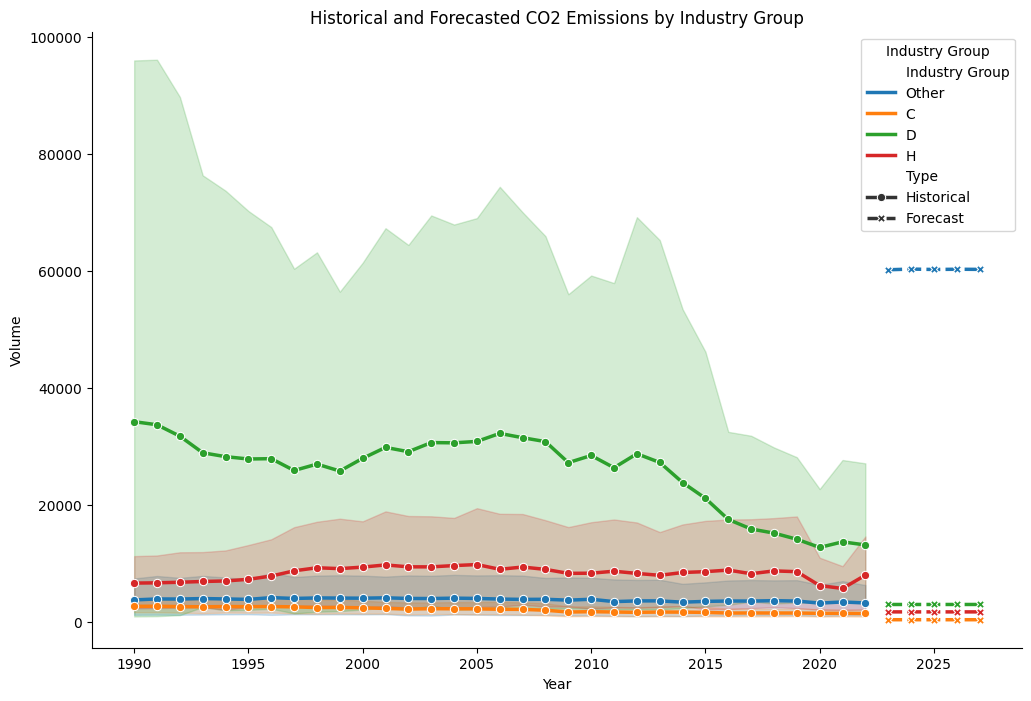

ADF Statistic: -1.9391299837337719
p-value: 0.31388283545500406
Tried ARIMA(0,0,0) - AIC:5626.091535055948
Tried ARIMA(0,0,1) - AIC:4643.657229325573
Tried ARIMA(0,0,2) - AIC:4460.509769142211
Tried ARIMA(0,0,3) - AIC:4577.375024887437
Tried ARIMA(0,1,0) - AIC:4268.644404284647
Tried ARIMA(0,1,1) - AIC:4269.079508628722
Tried ARIMA(0,1,2) - AIC:4270.740764013572
Tried ARIMA(0,1,3) - AIC:4268.174847886077
Tried ARIMA(1,0,0) - AIC:4291.723653109029
Tried ARIMA(1,0,1) - AIC:4291.3702348113875
Tried ARIMA(1,0,2) - AIC:4292.083179157582
Tried ARIMA(1,0,3) - AIC:4291.4591457187
Tried ARIMA(1,1,0) - AIC:4268.989174599201
Tried ARIMA(1,1,1) - AIC:4271.0067466756
Tried ARIMA(1,1,2) - AIC:4271.219200256694
Tried ARIMA(1,1,3) - AIC:4268.722540004166
Tried ARIMA(2,0,0) - AIC:4291.093738874735
Tried ARIMA(2,0,1) - AIC:4293.048638522951
Tried ARIMA(2,0,2) - AIC:4293.1308381070485
Tried ARIMA(2,0,3) - AIC:4292.711697508046
Tried ARIMA(2,1,0) - AIC:4270.99221412918
Tried ARIMA(2,1,1) - AIC:4272.073105

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
file_path = '/content/H, D, C & Other C02 Emissions.csv'
df = pd.read_csv(file_path)
df.head()

# Filter the DataFrame for the desired industry groups
industry_groups = ['Other', 'C', 'D', 'H']
df_filtered = df[df['Industry Group'].isin(industry_groups)]

# Create a dictionary to store the forecasts and evaluation metrics
forecasts = {}
evaluation_metrics = {}

# Iterate over the industry groups and create forecasts using ARIMA
for group in industry_groups:
    df_group = df_filtered[df_filtered['Industry Group'] == group]

    # Check if the DataFrame for the current group is empty
    if df_group.empty:
        print(f"No data available for industry group: {group}")
        continue

    # Prepare the data for ARIMA
    df_group = df_group.set_index('Year')
    df_group.index = pd.to_datetime(df_group.index, format='%Y')

    # Fit the ARIMA model
    model = ARIMA(df_group['Volume'], order=(1, 1, 1))
    model_fit = model.fit()

    # Create a DataFrame for future years and predict
    future_years = pd.date_range(start='2023', periods=5, freq='Y')
    forecast = model_fit.forecast(steps=5)
    forecast_df = pd.DataFrame({'Year': future_years, 'Volume': forecast})
    forecast_df['Industry Group'] = group
    forecast_df['Type'] = 'Forecast'
    forecasts[group] = forecast_df

    # Evaluate the model
    y_true = df_group['Volume']
    y_pred = model_fit.fittedvalues
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    evaluation_metrics[group] = {'MAE': mae, 'MSE': mse, 'R²': r2}

# Print the forecasts and evaluation metrics
for group, forecast in forecasts.items():
    print(f"\nForecast for {group}:")
    for i, row in forecast.iterrows():
        print(f"  {row['Year'].year}: {row['Volume']:.2f}")

    print(f"\nEvaluation Metrics for {group}:")
    print(f"  MAE: {evaluation_metrics[group]['MAE']:.2f}")
    print(f"  MSE: {evaluation_metrics[group]['MSE']:.2f}")
    print(f"  R²: {evaluation_metrics[group]['R²']:.2f}")

# Combine historical data and forecasts for plotting
forecast_df = pd.concat(forecasts.values())
forecast_df['Year'] = forecast_df['Year'].dt.year

# Add historical data to the DataFrame
df_filtered['Type'] = 'Historical'
combined_df = pd.concat([df_filtered, forecast_df])

# Plot the historical and forecasted data
plt.figure(figsize=(12, 8))
sns.lineplot(data=combined_df, x='Year', y='Volume', hue='Industry Group', style='Type', markers=True, linewidth=2.5)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Historical and Forecasted CO2 Emissions by Industry Group')
plt.xlabel('Year')
plt.ylabel('Volume')
plt.legend(title='Industry Group')
plt.show()



# Convert Year to datetime (if it's not already)
df_group_d.index = pd.to_datetime(df_group_d.index, format='%Y')
# Function to find the best ARIMA parameters using AIC
def best_arima_model(time_series):
    best_aic = np.inf
    best_order = None
    best_model = None

    # Iterate over p, d, q combinations
    for p in range(0, 4):
        for d in range(0, 2):
            for q in range(0, 4):
                try:
                    model = ARIMA(time_series, order=(p, d, q))
                    model_fit = model.fit()
                    print(f'Tried ARIMA({p},{d},{q}) - AIC:{model_fit.aic}')
                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_order = (p, d, q)
                        best_model = model_fit
                except Exception as e:
                    print(f"Error with ARIMA({p},{d},{q}): {e}")
    return best_model, best_order

# Apply the function to find the best model for group D
df_group_d = df_filtered[df_filtered['Industry Group'] == 'D']
df_group_d = df_group_d.set_index('Year')

# Convert Year to datetime (if it's not already)
df_group_d.index = pd.to_datetime(df_group_d.index, format='%Y')

# Check for stationarity (ADF Test)
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_group_d['Volume'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Finding the best ARIMA model
best_model, best_order = best_arima_model(df_group_d['Volume'])

# Check if we found a model
if best_model is not None:
    print(f"\nBest ARIMA order for Group D: {best_order}")

    # Forecast with the best model
    future_years_d = pd.date_range(start='2023', periods=5, freq='Y')
    forecast_d = best_model.forecast(steps=5)
    forecast_df_d = pd.DataFrame({'Year': future_years_d, 'Volume': forecast_d})
    forecast_df_d['Industry Group'] = 'D'
    forecast_df_d['Type'] = 'Forecast'

    # Replace the previous forecast for group D with the new one
    forecasts['D'] = forecast_df_d
else:
    print("No suitable ARIMA model found for Group D.")




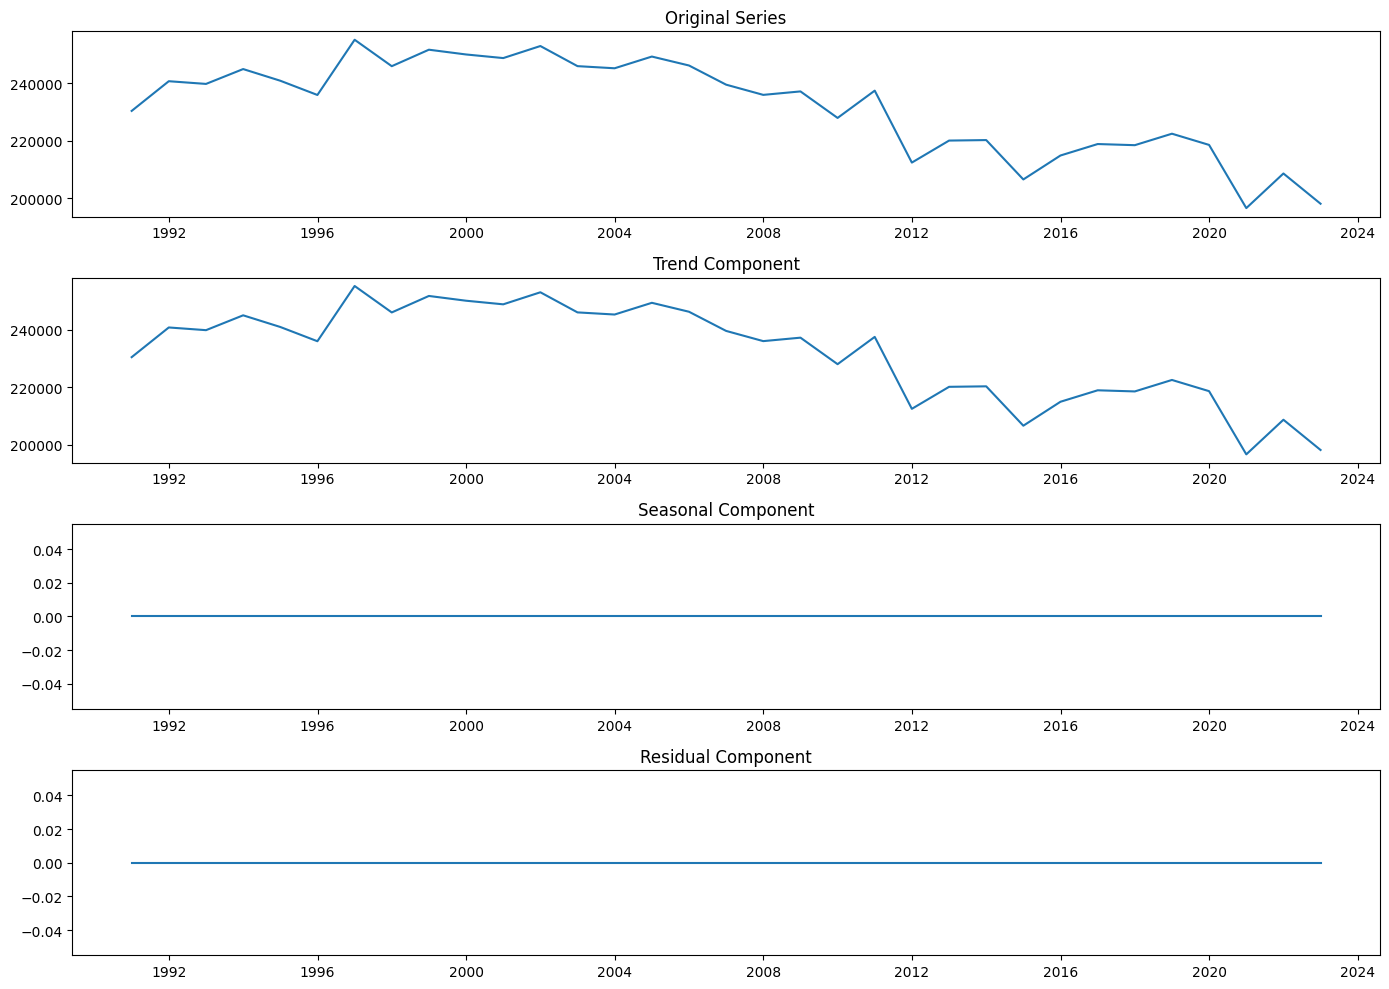

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Example with one of the industry groups
df_group = df_filtered[df_filtered['Industry Group'] == 'Other']
df_group = df_group.set_index('ds')['y'] # Set 'ds' as index, which corresponds to 'Year'

# Set frequency of the DateTimeIndex (assuming yearly data)
df_group.index = pd.to_datetime(df_group.index, format='%Y')
df_group = df_group.resample('Y').sum() #This line of code sets the frequency of the time series by resampling it to an annual frequency ('Y') and summing the values within each year.

# Decompose, now with a frequency set for the index
decomposition = seasonal_decompose(df_group, model='additive')
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()
residual = decomposition.resid.dropna()

plt.figure(figsize=(14, 10))
plt.subplot(4, 1, 1)
plt.plot(df_group, label='Original')
plt.title('Original Series')
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.title('Trend Component')
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.title('Seasonal Component')
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.title('Residual Component')
plt.tight_layout()
plt.show()

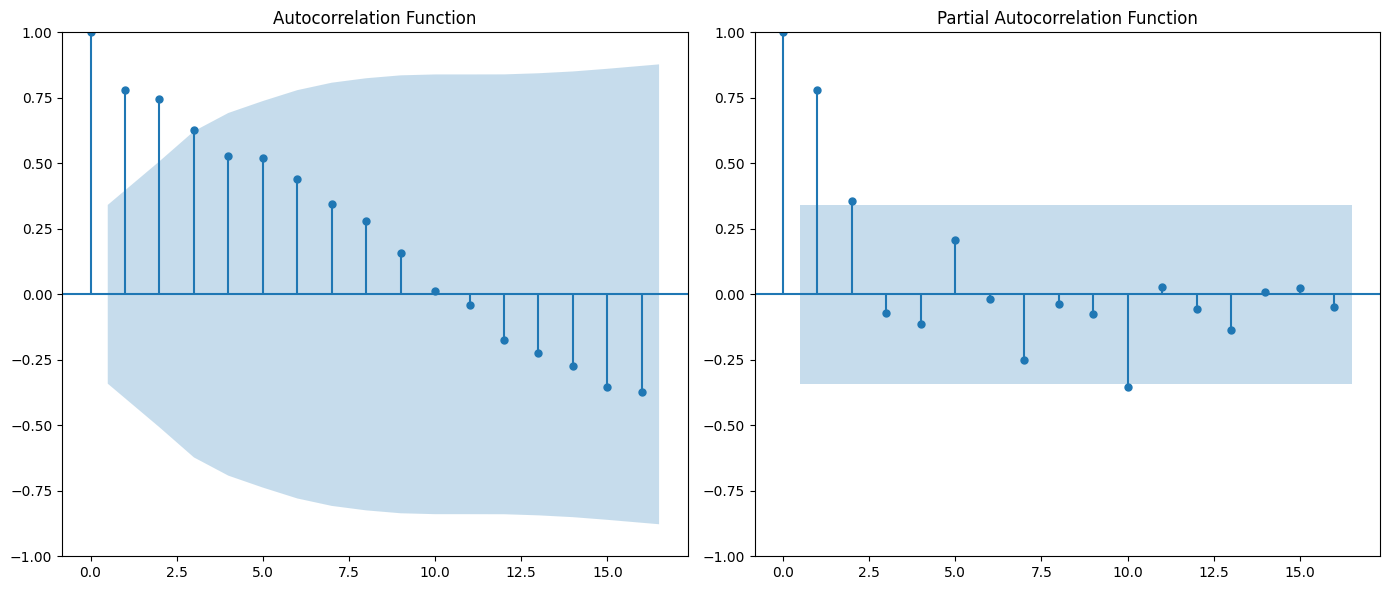

In [75]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Calculate the maximum number of lags (should be at most half the sample size)
max_lags = len(df_group) // 2

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)

# Use the calculated maximum lags for the ACF plot
plot_acf(df_group, ax=plt.gca(), lags=max_lags)
plt.title('Autocorrelation Function')

plt.subplot(1, 2, 2)

# Use the calculated maximum lags for the PACF plot
plot_pacf(df_group, ax=plt.gca(), lags=max_lags)
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

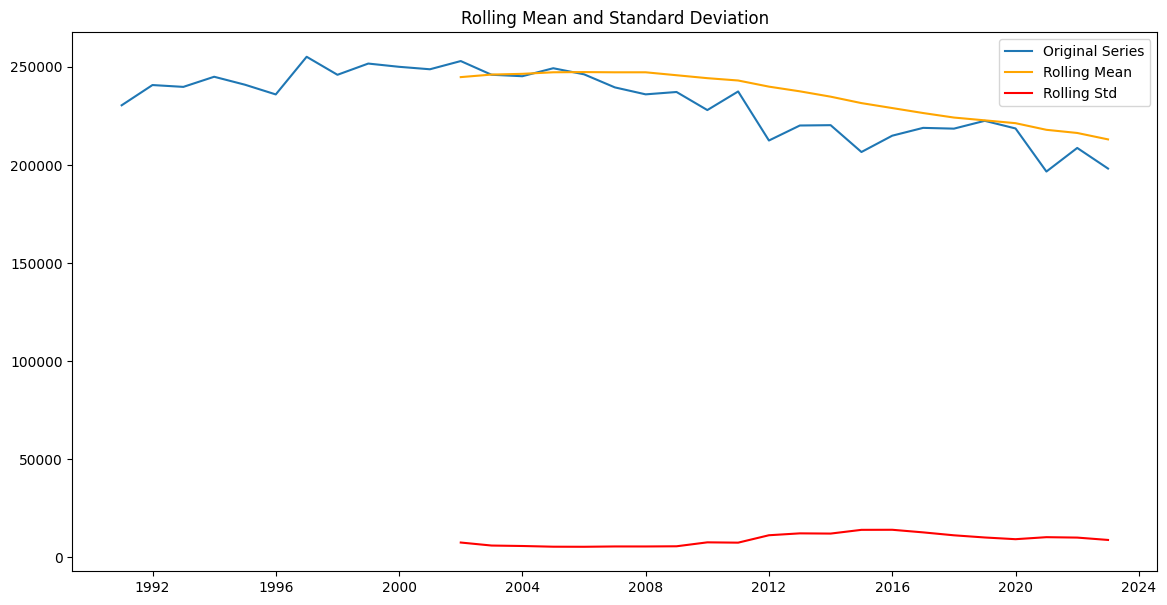

In [78]:
rolling_mean = df_group.rolling(window=12).mean()
rolling_std = df_group.rolling(window=12).std()

plt.figure(figsize=(14, 7))
plt.plot(df_group, label='Original Series')
plt.plot(rolling_mean, label='Rolling Mean', color='orange')
plt.plot(rolling_std, label='Rolling Std', color='red')
plt.title('Rolling Mean and Standard Deviation')
plt.legend()
plt.show()

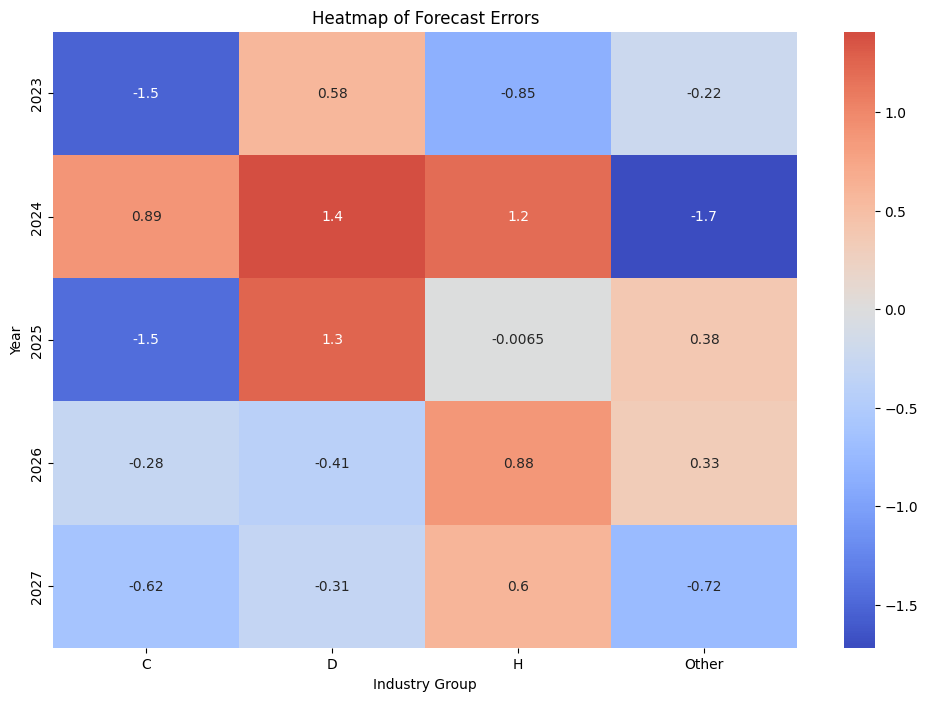

In [80]:
import numpy as np
import seaborn as sns

# Assuming df_errors contains forecast errors
df_errors = pd.DataFrame({
    'Year': [2023, 2024, 2025, 2026, 2027] * len(industry_groups),
    'Error': np.random.normal(0, 1, len(industry_groups) * 5),  # Replace with actual errors
    'Industry Group': industry_groups * 5
})

# Pivot data for heatmap, providing arguments as keywords
heatmap_data = df_errors.pivot(index='Year', columns='Industry Group', values='Error')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Forecast Errors')
plt.show()